# Starbucks Capstone Challenge

## Introduction

- This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

- Not all users receive the same offer, and that is the challenge to solve with this data set.

- Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

- Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only $5$ days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

- You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

- Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.


## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

### profile.json

* `age` (int) - age of the customer 
* `became_member_on` (int) - date when customer created an app account
* `gender` (str) - gender of the customer (note some entries contain '`O`' for other rather than M or F)
* `id` (str) - customer id
* `income` (float) - customer's income

### portfolio.json

* `id` (string) - offer id
* `offer_type` (string) - type of offer ie BOGO, discount, informational
* `difficulty` (int) - minimum required spend to complete an offer
* `reward` (int) - reward given for completing an offer
* `duration` (int) - time for offer to be open, in days
* `channels` (list of strings)



### transcript.json

* `event` (`str`) - record description (ie transaction, offer received, offer viewed, etc.)
* `person` (`str`) - customer id
* `time` (`int`) - time in hours since start of test. The data begins at time `t=0`
* `value` - (`dict of strings`) - either an offer id or transaction amount depending on the record

# Load Lib

In [1]:
from imp import reload 
from tabulate import tabulate

In [2]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix


In [4]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['lines.linewidth'] = 2


font = {'family': 'serif',
        'color':  '#2E86C1',
        'weight': 'normal',
        'size': 20,
        }

base_color = sns.color_palette()[0]

In [6]:
import helper.print as p
from helper.confusion_matrix import make_confusion_matrix

In [7]:
reload(p)

<module 'helper.print' from '/home/mazzam/Projects/Starbucks Capstone/helper/print.py'>

# Import Datasets

In [8]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [9]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [10]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [11]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


# Assessing

## profile

In [12]:
# check the type on columns
p.print_comment('check the type on columns')

profile.info()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the type on columns ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
# check the null values
p.print_comment('check the null values')

profile.isnull().sum()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the null values ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
p.print_comment('check the age column')

# check the age column
print(profile.age.value_counts(), '\n')

p.print_comment('describe of age column')

# check the describe of age column
print(profile.age.describe(), '\n')

p.print_comment('check the age 118')

# check the age 118
x = profile[profile.age == 118]
print(x[:2])
x.age.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the age column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Describe of age column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the age 118 ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

  gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN


118    2175
Name: age, dtype: int64

In [15]:
# check income column
p.print_comment('describe of income column')
profile.income.describe()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Describe of income column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [16]:
# check duplicate
p.print_comment('check duplicate')
profile[profile.duplicated()]

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check duplicate ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



,gender,age,id,became_member_on,income


## portfolio

In [17]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
# check columns type
p.print_comment('check columns type')

portfolio.info()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check columns type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [19]:
# check offer_type column

p.print_comment('check offer_type column')
portfolio.offer_type.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

## transcript

In [20]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [21]:
# check column type
p.print_comment('check column type')
transcript.info()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check column type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
# check event column
p.print_comment('check event column')
transcript.event.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [23]:
# check time column
p.print_comment('check time column')
transcript.time.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check time column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

In [24]:
# check value column
p.print_comment('check value column')
transcript.value

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

## Observation

**Profile Dataset**
- [x] `became_member_on` not date
- [x] `gender`there are $2175$ Missing value
- [x] `income`there are $2175$ Missing value
- [x] `age` there are $2175$ persons have 118 years it seem to be outlier. we can also notice that is located in same row with `gender` and `income` that have `NaN` value
- [x] `id` change his name to `customer_id`
- [x] `gender` need to encode
- [x] `become_member_on` need to encode

---

**Portfolio Dataset**
- [x] `id` change his name to `offer_id`
- [x] `channels` need to encode
- [x] `offer_type` need to encode
- [x] `offer_id` create column has offer name like `offer_1`

---

**Transcript Dataset**
- [x] `time` convert to days
- [x] `person` change his name to `customer_id`
- [x] `value` extract `offer_id` and `amount`
- [x] `event` need to encode

# Data Wrangling & Feature Enginnering

## profile

### 
**Define**: `became_member_on` not date

In [25]:
# check became_member_on column
p.print_comment('check became_member_on column')

print(profile.became_member_on.value_counts())

# Code: convert date string to date
p.print_comment('Code:convert date string to date')

profile['became_member_on'] =\
    pd.to_datetime(profile.became_member_on, format="%Y%m%d")
print('done')


# test : convert date string to date
p.print_comment('test:convert date string to date')
print(profile.became_member_on)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check became_member_on column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

20171207    43
20170819    42
20171007    40
20171113    39
20170928    38
            ..
20141212     1
20140412     1
20140621     1
20141023     1
20130922     1
Name: became_member_on, Length: 1716, dtype: int64
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code:convert date string to date ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

done
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test:convert date string to date ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

0       2017-02-12
1       2017-07-15
2       2018-07-12
3       2017-05-09
4       2017-08-04
           ...    
16995   2018-06-04
16996   2018-07-13
16997   2017-01-26
16998   2016-03-07
16999   2017-07-22
Name: became_member_on, Length: 17000, dtype: datetime64[ns]


### 
**Define**: `age` there are $2175$ persons have 118 years it seem to be outlier. we can also notice that is located in same row with `gender` and `income` that have `NaN` value

**Define**: `gender`there are $2175$ Missing value

**Define**: `income`there are $2175$ Missing value

In [26]:
# code: drop nan value rows
p.print_comment('code: drop nan value rows')
profile.dropna(inplace=True)
profile.reset_index(drop=True, inplace=True)
p.print_done()

# test: 
p.print_comment('test:')
profile.isnull().sum()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: drop nan value rows ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

### 
**Define**: id change his name to customer_id

In [27]:
# check columns name
p.print_comment('check columns name')
print(profile.columns)


# code: change id name
try:
    p.print_comment('code: change id name')
    profile.rename(columns={"id": "customer_id"}, inplace=True)
except Exception as e: print(e)
else:
    p.print_done()


# test:
p.print_comment('test: columns name')
print(profile.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: change id name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')


### 
**Define**: `gender` need to encode

In [28]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [29]:
encoder = OneHotEncoder(sparse=False)


try:
    # code: encode gender column
    p.print_comment('code: encode gender column')
    onehot = encoder.fit_transform(profile[['gender']])
    # print(onehot)

    profile[['Female', 'Male', 'other']] = onehot
    
except Exception as e: print(e)
else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: encode gender column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 



In [30]:
profile.head(2)

,gender,age,customer_id,became_member_on,income,Female,Male,other
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1.0,0.0,0.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1.0,0.0,0.0


### 
**Define**`become_member_on` need to encode

In [31]:
# code: encode become_member_on
p.print_comment('code: encode become_member_on')
try:
    profile['become_member_on_year'] = profile.became_member_on.dt.year.astype(str)
    profile['become_member_on_month'] = profile.became_member_on.dt.month.astype(str)
    profile['become_member_on_day'] = profile.became_member_on.dt.day.astype(str)
except Exception as e: print(e)
else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: encode become_member_on ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 



In [32]:
profile

,gender,age,customer_id,became_member_on,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1.0,0.0,0.0,2017,7,15
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1.0,0.0,0.0,2017,5,9
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0.0,1.0,0.0,2018,4,26
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0.0,1.0,0.0,2018,2,9
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0.0,1.0,0.0,2017,11,11
...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1.0,0.0,0.0,2018,6,4
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0.0,1.0,0.0,2018,7,13
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0.0,1.0,0.0,2017,1,26
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1.0,0.0,0.0,2016,3,7


In [33]:
# drop become_member_on column
p.print_comment('drop become_member_on column')

profile.drop('became_member_on', axis=1, inplace=True)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Drop become_member_on column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



## portfolio 

### 
**Define**: `id` change his name to `offer_id`

In [34]:
# check columns name
p.print_comment('check columns name')
print(portfolio.columns)


# code: change id name
try:
    p.print_comment('code: change id name')
    portfolio.rename(columns={"id": "offer_id"}, inplace=True)
except Exception as e: print(e)
else:
    p.print_done()


# test:
p.print_comment('test: columns name')
print(portfolio.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: change id name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')


### 
**Define**: `channels` need to encode

In [35]:
# check the type
p.print_comment('check the type')
type(portfolio.channels[0])

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



list

In [36]:
# return all channels
p.print_comment('return all channels')
try:
    print(portfolio.channels.value_counts())
except: pass

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return all channels ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64


In [37]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
# code: split channels column
p.print_comment('code: split channels column')

def split_channels(channels_list):
    """split channels to columns"""
    if channel in channels_list:
        return 1
    else:
        return 0
try:
    all_channels = ['web', 'email', 'mobile', 'social']
    for channel in all_channels:
        portfolio.loc[:, channel] = portfolio.channels.apply(split_channels)
    
    
except: pass

else: p.print_done()


# test
p.print_comment('test: split channels column')

portfolio.head(2)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: split channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: split channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [39]:
try:
    p.print_comment('Drop channels column')
    portfolio.drop('channels', axis=1, inplace=True)
except: pass
else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Drop channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 



### 
**Define**: `offer_type` need to encode


In [40]:
# return all offer_type

p.print_comment('return all offer_type')
offer_type = portfolio.offer_type.unique()
offer_type

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return all offer_type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



array(['bogo', 'informational', 'discount'], dtype=object)

In [41]:
portfolio.head(2)

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [42]:
# code: split offer_type column
p.print_comment('code: split offer_type column')

def split_offer_type(val):
    """split offer_type column"""
    if val == offer:
        return 1
    else:
        return 0

try:
    for offer in offer_type:
        portfolio[offer] = portfolio.offer_type.apply(split_offer_type)
    
except: pass
else: p.print_done()
    

# test
p.print_comment('test: split offer_type column')
portfolio.head(2)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: split offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: split offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0


### 
**Define** `offer_id` create column has offer name like offer_1

In [43]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


In [44]:
# code: create offer_name column
p.print_comment('code: create offer_name column')

try: 
    lst = range(1,portfolio.shape[0]+1)
    x = [f"offer_{x}" for x in lst]
    portfolio['offer_name'] = x

except: pass

else: 
    p.print_done()
    print(portfolio[['offer_id','offer_name']])


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: create offer_name column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

                           offer_id offer_name
0  ae264e3637204a6fb9bb56bc8210ddfd    offer_1
1  4d5c57ea9a6940dd891ad53e9dbe8da0    offer_2
2  3f207df678b143eea3cee63160fa8bed    offer_3
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    offer_4
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    offer_5
5  2298d6c36e964ae4a3e7e9706d1fb8c2    offer_6
6  fafdcd668e3743c1bb461111dcafc2a4    offer_7
7  5a8bc65990b245e5a138643cd4eb9837    offer_8
8  f19421c1d4aa40978ebb69ca19b0e20d    offer_9
9  2906b810c7d4411798c6938adc9daaa5   offer_10


## transcript

### 
**Define**: `time` convert to days

In [45]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [46]:
# check time column
p.print_comment('check time column')
print(transcript.time.value_counts().sort_index()[:5])

# check the type
p.print_comment('check the type')
print(type(transcript.time[0]))

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check time column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

0     15561
6      2506
12     2215
18     2015
24     1921
Name: time, dtype: int64
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check the type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

<class 'numpy.int64'>


In [47]:
def convert_time_day(val):
    """convert from time to days"""
    return val / 24

try:
    # code: convert time to days
    p.print_comment('code: convert time to days')

    transcript['days'] = transcript.time.apply(convert_time_day)

except Exception as e: print(e)

else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: convert time to days ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 



In [48]:
# test: convert time to days
p.print_comment('test: convert time to days')

transcript.days[-10:]

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: convert time to days ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



306524    29.75
306525    29.75
306526    29.75
306527    29.75
306528    29.75
306529    29.75
306530    29.75
306531    29.75
306532    29.75
306533    29.75
Name: days, dtype: float64

### 
**Define**: `person` change his name to `customer_id`

In [49]:
# return columns name

p.print_comment('return columns name')
print(transcript.columns)

# code: change column name
try:
    p.print_comment('code: change column name')
    transcript.rename(columns={"person": "customer_id"}, inplace=True)
except: pass
else: p.print_done()
    
# test: change column name
p.print_comment('return columns name')
print(transcript.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['person', 'event', 'value', 'time', 'days'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: change column name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Index(['customer_id', 'event', 'value', 'time', 'days'], dtype='object')


### 
**Define**: `value` extract `offer_id` and `amount`

In [50]:
# check value column
p.print_comment('check value column')
transcript.value

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Check value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [51]:
# return the keys in value column
p.print_comment('return the keys in value column')

keys = []
def get_keys(val):
    """return available keys"""
    if list(val.keys()) not in keys:
        keys.append(list(val.keys()))
    
    
transcript.value.apply(get_keys)

keys = [ item for elem in keys for item in elem]
print(keys)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return the keys in value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

['offer id', 'amount', 'offer_id', 'reward']


In [52]:
transcript.tail(10)

,customer_id,event,value,time,days
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,{'amount': 25.14},714,29.75
306525,eec70ab28af74a22a4aeb889c0317944,transaction,{'amount': 43.58},714,29.75
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,29.75
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,29.75
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,29.75
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29.75
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,29.75


In [53]:
def split_key(val):
    """split key column"""
    if list(val.keys())[0].startswith(key[:2]):
        return list(val.values())[0]
    else:
        return 0
    
try:  
    # code: split value column
    p.print_comment('code: splite value column')
    
    for key in keys[1:3]:
        transcript[key] = transcript.value.apply(split_key)
except: pass

else: p.print_done()
    
# test: split value column
p.print_comment('test: splite value column')
transcript.tail(10)



▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: splite value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: splite value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



,customer_id,event,value,time,days,amount,offer_id
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,{'amount': 25.14},714,29.75,25.14,0
306525,eec70ab28af74a22a4aeb889c0317944,transaction,{'amount': 43.58},714,29.75,43.58,0
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,29.75,22.64,0
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,29.75,0.00,fafdcd668e3743c1bb461111dcafc2a4
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,29.75,2.20,0
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29.75,1.59,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29.75,9.53,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29.75,3.61,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29.75,3.53,0
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,29.75,4.05,0


In [54]:
# drop value column
p.print_comment('drop value column')

transcript.drop('value', axis=1, inplace=True)

# test
p.print_comment('test')

transcript.columns

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Drop value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



Index(['customer_id', 'event', 'time', 'days', 'amount', 'offer_id'], dtype='object')

### 
**Define**: `event` need to encode

In [55]:
# return unique value in event column
p.print_comment('return unique value in event column')

event_list = transcript.event.unique()
event_list

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Return unique value in event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [56]:
transcript.tail(50)

,customer_id,event,time,days,amount,offer_id
306484,a4c2dd694269444085976f10b9b225f6,transaction,714,29.75,28.58,0
306485,4b59509988d34c7298119a840c946453,transaction,714,29.75,0.06,0
306486,92153f7cdda8486b9a2214ceb11b1a17,transaction,714,29.75,4.39,0
306487,3c88696ac23741cb8a709d656fe5ccdf,transaction,714,29.75,25.76,0
306488,1b24e887d980450497b631d8756128e6,transaction,714,29.75,0.35,0
306489,1c71315203b746b786c43ce12d7e97fe,transaction,714,29.75,20.84,0
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,29.75,0.00,3f207df678b143eea3cee63160fa8bed
306491,693082e8ccf9458a88c428779cf556a6,transaction,714,29.75,2.16,0
306492,d4f6205a98b4420082aae16e5a93655a,transaction,714,29.75,1.22,0
306493,7b2939e61c324b2087328c4b6fee2632,transaction,714,29.75,26.41,0


In [57]:
def split_event(val):
    """split event column"""
    if val == event:
        return 1
    else:
        return 0

try:
    # code: split event column
    p.print_comment('code: split event column')
    
    for event in event_list:
        transcript[event] = transcript.event.apply(split_event)
except: pass
else: p.print_done()
    

# test: split event column
p.print_comment('test: split event column')

transcript.tail(50)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code: split event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: split event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



,customer_id,event,time,days,amount,offer_id,offer received,offer viewed,transaction,offer completed
306484,a4c2dd694269444085976f10b9b225f6,transaction,714,29.75,28.58,0,0,0,1,0
306485,4b59509988d34c7298119a840c946453,transaction,714,29.75,0.06,0,0,0,1,0
306486,92153f7cdda8486b9a2214ceb11b1a17,transaction,714,29.75,4.39,0,0,0,1,0
306487,3c88696ac23741cb8a709d656fe5ccdf,transaction,714,29.75,25.76,0,0,0,1,0
306488,1b24e887d980450497b631d8756128e6,transaction,714,29.75,0.35,0,0,0,1,0
306489,1c71315203b746b786c43ce12d7e97fe,transaction,714,29.75,20.84,0,0,0,1,0
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,29.75,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0,0
306491,693082e8ccf9458a88c428779cf556a6,transaction,714,29.75,2.16,0,0,0,1,0
306492,d4f6205a98b4420082aae16e5a93655a,transaction,714,29.75,1.22,0,0,0,1,0
306493,7b2939e61c324b2087328c4b6fee2632,transaction,714,29.75,26.41,0,0,0,1,0


In [58]:
# rename columns
p.print_comment('rename columns')

transcript.rename(columns={ "offer received": "offer_received", 
                            "offer viewed": "offer_viewed",
                            "offer completed": "offer_completed"},
                 inplace=True)

# test: rename columns
p.print_comment('test: rename columns')
transcript.columns

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Rename columns ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Test: rename columns ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 



Index(['customer_id', 'event', 'time', 'days', 'amount', 'offer_id',
       'offer_received', 'offer_viewed', 'transaction', 'offer_completed'],
      dtype='object')

## Create offer dataframe

create offer dataframe from people that have offers

In [59]:
# create offer dataframe 
offer = transcript[transcript.event != 'transaction']
offer.head()

,customer_id,event,time,days,amount,offer_id,offer_received,offer_viewed,transaction,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


## Create successful offer column

**Note**: that the offer be success if a customer completed an offer and viewed it and if not viewed the offer become not success offer

In [60]:
# check if the offer is success or not

# Group-by value counts in event column 
offer_customer = offer.pivot_table(index=['customer_id','offer_id'],\
                 columns='event', aggfunc='size', fill_value=0)
offer_customer.reset_index(level=[0,1], inplace=True)

# creat successful_offer column 
offer_customer['successful_offer'] =\
    offer_customer['offer completed'] * offer_customer['offer viewed']

offer_customer['successful_offer'] = offer_customer['successful_offer'].apply(lambda x: 1 if x > 0 else 0)

## Merge datasets
create overall dataset that a combination from offer_customer dataset and profile dataset and portoflio dataset

In [61]:
# merge dataset profile and portolio and offer_customer
overall_df = pd.merge(offer_customer,portfolio,on='offer_id', how='left')
overall_df = pd.merge(overall_df,profile,on='customer_id')
overall_df

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,reward,difficulty,duration,offer_type,...,offer_name,gender,age,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,10,7,discount,...,offer_10,M,33,72000.0,0.0,1.0,0.0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,0,4,informational,...,offer_3,M,33,72000.0,0.0,1.0,0.0,2017,4,21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0,3,informational,...,offer_8,M,33,72000.0,0.0,1.0,0.0,2017,4,21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,5,5,5,bogo,...,offer_9,M,33,72000.0,0.0,1.0,0.0,2017,4,21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2,10,10,discount,...,offer_7,M,33,72000.0,0.0,1.0,0.0,2017,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,1,5,5,5,bogo,...,offer_9,M,34,34000.0,0.0,1.0,0.0,2017,1,23
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,5,20,10,discount,...,offer_5,F,45,62000.0,1.0,0.0,0.0,2016,11,25
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,1,2,10,7,discount,...,offer_10,F,45,62000.0,1.0,0.0,0.0,2016,11,25
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,5,5,7,bogo,...,offer_4,F,45,62000.0,1.0,0.0,0.0,2016,11,25


# Export clean data

In [62]:
# export clean data
p.print_comment('export clean data')

profile.to_csv('data/clean_profile.csv', index=False)
portfolio.to_csv('data/clean_portfolio.csv', index=False)
transcript.to_csv('data/clean_transcript.csv', index=False)
overall_df.to_csv('data/overall_df.csv', index=False)

p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Export clean data ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ 

Celebration: your job completed 🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉 



# Exploratory analysis

In [63]:
portfolio = pd.read_csv('data/clean_portfolio.csv')
profile = pd.read_csv('data/clean_profile.csv')
transcript = pd.read_csv('data/clean_transcript.csv')
overall_df = pd.read_csv('data/overall_df.csv')

## Profile

In [64]:
profile['become_member_on_month'] = profile.become_member_on_month.astype(str)
profile['become_member_on_year'] = profile.become_member_on_year.astype(str)
profile['become_member_on_day'] = profile.become_member_on_day.astype(str)

### Gender Distribution

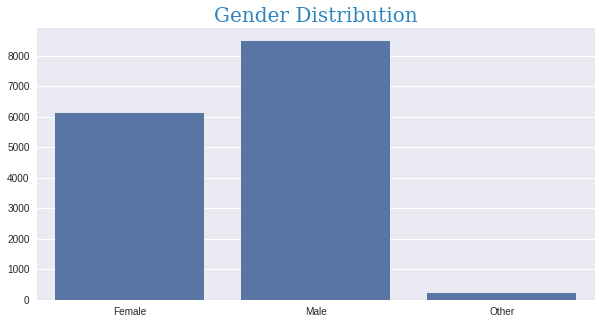

In [65]:
gender_count = [profile.Female.sum(), profile.Male.sum(), profile.other.sum()]
x_label = ['Female', 'Male', 'Other']
sns.barplot(y = gender_count, x = x_label , color=base_color);
plt.title('Gender Distribution', fontdict=font);


> we can notice that most of users are Male

### Income Distribution

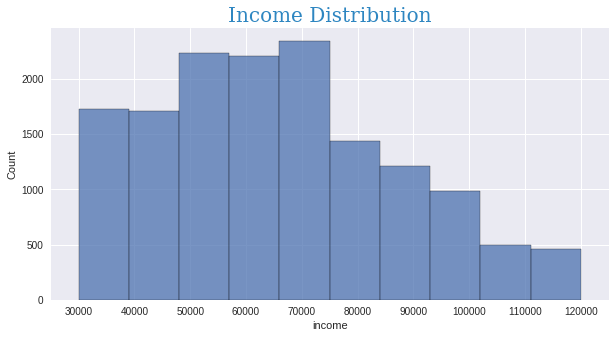

In [66]:
bin_edges = np.arange(0, profile['income'].max()+1, 10000)

sns.histplot(profile['income'],bins=10);
plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution', fontdict=font);

> We can notice that the most income between $50000 \to 70000$

### Age Distribution

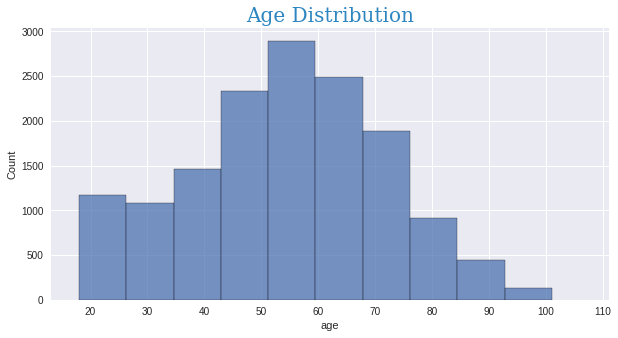

In [67]:
bin_edges = np.arange(0, profile['age'].max()+10, 10)
sns.histplot(profile['age'],bins=10);
plt.xticks(bin_edges)
plt.xlim(profile.age.min()-5, profile.age.max()+10)
plt.title('Age Distribution', fontdict=font);

> We can notice that the most age is between 40 to 75

### New Member based of Year

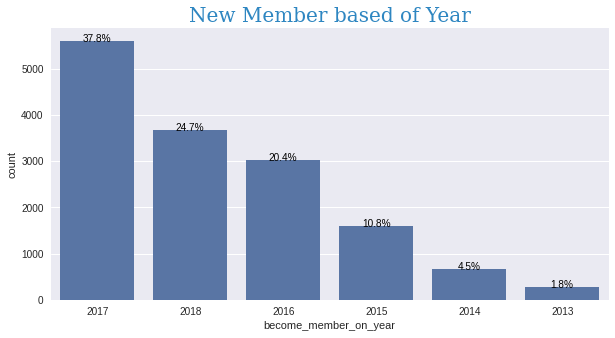

In [68]:
cat_order = profile['become_member_on_year'].value_counts().index
sns.countplot(data = profile, x = 'become_member_on_year', color=base_color, 
              order=cat_order)
plt.title('New Member based of Year', fontdict=font)

# add annotations
n_points = profile.shape[0]
cat_counts = profile['become_member_on_year'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')


> 2017 has the highest number of new members.

### New Member based of Month

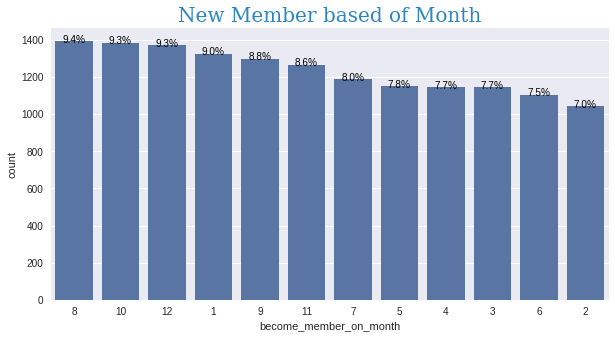

In [69]:
cat_order = profile['become_member_on_month'].value_counts().index
sns.countplot(data = profile, x = 'become_member_on_month', color=base_color, 
              order=cat_order)
plt.title('New Member based of Month', fontdict=font)

# add annotations
n_points = profile.shape[0]
cat_counts = profile['become_member_on_month'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')


> We can notice grow in member based on month is almost equal

### New Memeber based on Year and Gender

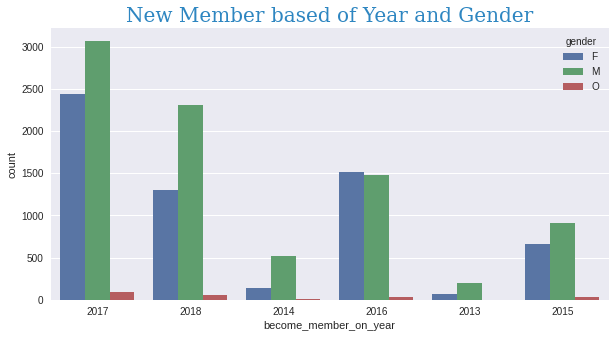

In [70]:
sns.countplot(data = profile, x = 'become_member_on_year', hue = 'gender')
plt.title('New Member based of Year and Gender', fontdict=font);

> We can notice that most new member are Male

### Income based on Gender

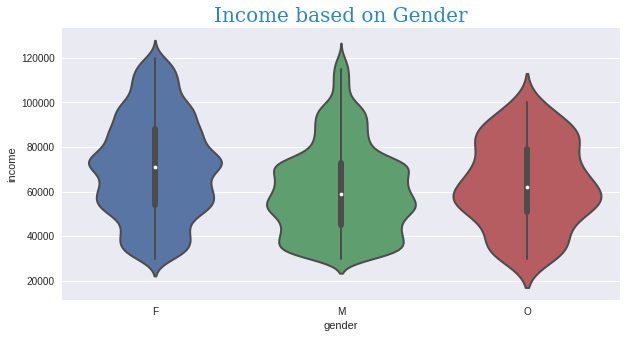

In [71]:
sns.violinplot(data = profile, y = 'income', x = 'gender');
plt.title('Income based on Gender', fontdict=font);

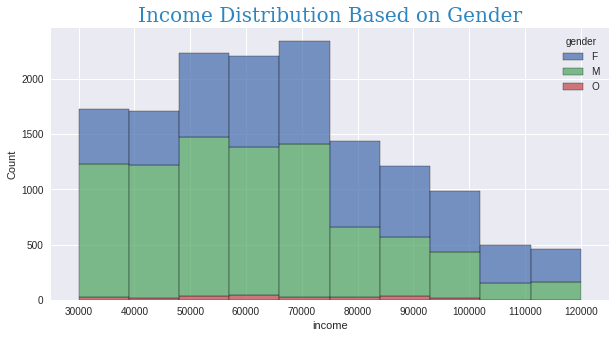

In [72]:
sns.histplot(data=profile, x="income", hue="gender", multiple="stack", 
            bins=10);

bin_edges = np.arange(0, profile['income'].max()+1, 10000)

plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution Based on Gender', fontdict=font);

> We can notice that the count Female gender is the highest one

## transcript

### Event Distribution

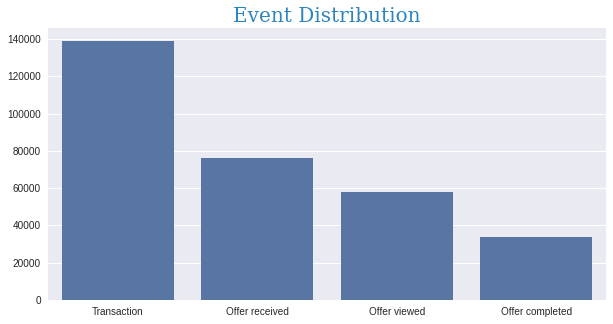

In [73]:
# create event list
x_value = ['Offer received','Offer viewed','Transaction','Offer completed']
y_value = [transcript.offer_received.sum(), transcript.offer_viewed.sum(),
    transcript.transaction.sum(), transcript.offer_completed.sum()]

# sort values
x_value = [x for _,x in sorted(zip(y_value,x_value), reverse=True)]
y_value.sort(reverse=True)

# show graph
sns.barplot(y = y_value, x = x_value , color=base_color);
plt.title('Event Distribution', fontdict=font);

> We can notice that most of offers are just received and viewed

### Offers Distribution

In [74]:
table = [
    ['Number of customer made transaction' ,
         transcript[transcript.transaction == 1].customer_id.count(),
    '100%'],
    
    
    ['Number of unique customers made transaction',
        transcript[transcript.transaction == 1].customer_id.nunique(),
    f"{round((16578/138953)*100, 2)}%"],
    
    
    ['Number of customers who recived offers', 
        transcript[transcript.transaction != 1].customer_id.count(),
    '100%'],
    
    
    ['Number of unique customers who recived offers',
        transcript[transcript.transaction != 1].customer_id.nunique(),
    f"{round((16994/167581)*100, 2)}%"]
        
        ]

header = ['Notice', 'Number', 'Percentage']

print(tabulate(table,header, tablefmt="simple"))

Notice                                           Number  Percentage
---------------------------------------------  --------  ------------
Number of customer made transaction              138953  100%
Number of unique customers made transaction       16578  11.93%
Number of customers who recived offers           167581  100%
Number of unique customers who recived offers     16994  10.14%


> We can notice that there are alot of repeated offers to the same customer
also we can notice that the customers who made transaction mostly are the same customers no new customer come

## Overall dataframe

### Distribution of Successfule offers

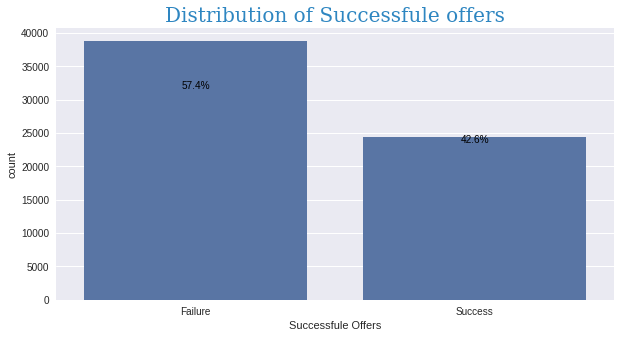

In [75]:
x = overall_df['successful_offer'].value_counts()
x.index = ['Failure', 'Success']

ax = sns.countplot(data = offer_customer, x = 'successful_offer', color = base_color)
plt.title('Distribution of Successfule offers', fontdict=font);
ax.set_xticklabels(['Failure', 'Success']);
ax.set_xlabel('Successfule Offers');

# add annotations
n_points = overall_df.shape[0]
cat_counts = x
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')

> The Percentage of failure offers greater than success offers

### Distribution of Success based on offer type

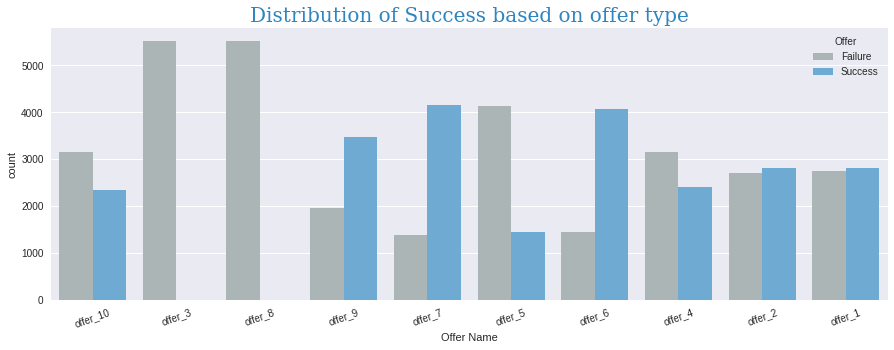

In [76]:
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = overall_df, x = 'offer_name', hue = 'successful_offer', 
                  palette=['#AAB7B8', '#5DADE2'])
ax.legend(['Failure', 'Success'], title = 'Offer', );
plt.title('Distribution of Success based on offer type', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offer Name');

> There are alot of offers need to review because is not success like offer_8. <br>
offer_7, offer_9, offer_6 have a successeful story

### Distribution of Offers based on Gender

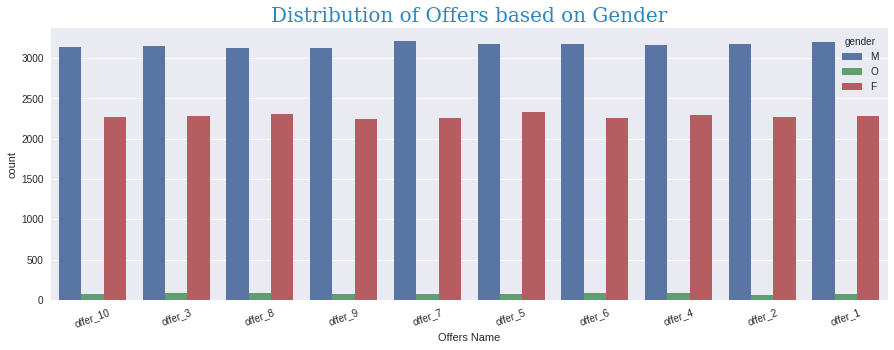

In [77]:
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = overall_df, x = 'offer_name', hue = 'gender', 
                   )
plt.title('Distribution of Offers based on Gender', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offers Name');

> We can notice that male have more offers then female and that is normal because the count of male is more than female

### Distribution of Success based on Gender

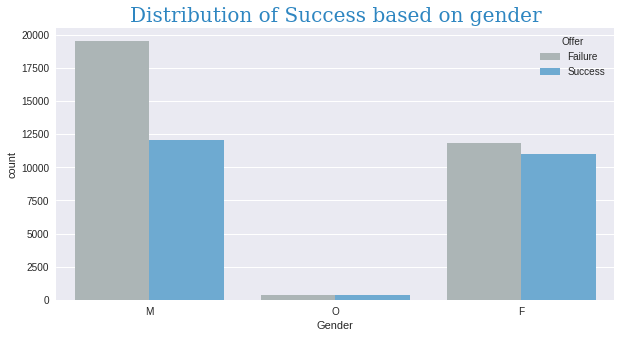

In [78]:
ax = sns.countplot(data = overall_df, x = 'gender', hue = 'successful_offer', 
                   palette=['#AAB7B8', '#5DADE2'])
ax.legend(['Failure', 'Success'], title = 'Offer', );
plt.title('Distribution of Success based on gender', fontdict=font);
plt.xlabel('Gender');

> The offers is failed with male more than female

### Distribution of of Success offers based on Gender

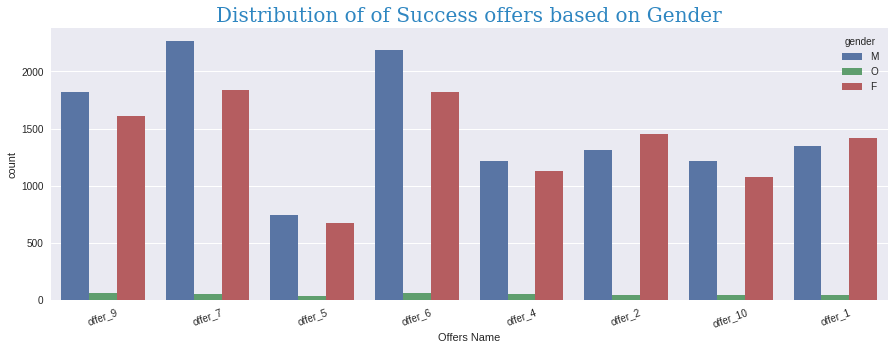

In [79]:
succes_offer = overall_df[overall_df.successful_offer == 1]
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = succes_offer, x = 'offer_name', hue = 'gender', 
                   )
plt.title('Distribution of of Success offers based on Gender', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offers Name');

> We can notice that the success offer in female is more than the other despite of the male in data set is more than female

### Income Distribution Based on Success

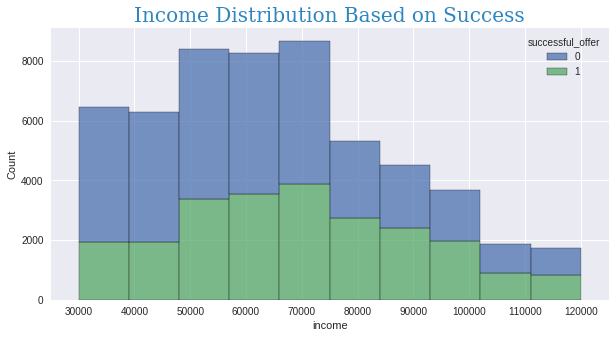

In [80]:
ax = sns.histplot(data=overall_df, x="income", hue="successful_offer", multiple="stack", 
            bins=10);

bin_edges = np.arange(0, profile['income'].max()+1, 10000)

plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution Based on Success', fontdict=font);

> We can notice that the income does not have any role in the reject offers

# Modeling

I will build a model that **predicts whether or not someone will respond to an offer**. 

In [81]:
overall_df = pd.read_csv('data/overall_df.csv')

## Data Preparation

In [82]:
overall_df.head()

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,reward,difficulty,duration,offer_type,...,offer_name,gender,age,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,10,7,discount,...,offer_10,M,33,72000.0,0.0,1.0,0.0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,0,4,informational,...,offer_3,M,33,72000.0,0.0,1.0,0.0,2017,4,21
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0,3,informational,...,offer_8,M,33,72000.0,0.0,1.0,0.0,2017,4,21
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,5,5,5,bogo,...,offer_9,M,33,72000.0,0.0,1.0,0.0,2017,4,21
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2,10,10,discount,...,offer_7,M,33,72000.0,0.0,1.0,0.0,2017,4,21


In [83]:
# create x and y data
X = overall_df.drop(['customer_id', 'offer_id', 
                     'offer_type', 'gender', 'offer_name', 'successful_offer', 
                    'offer received', 'social', 'discount', 'other', # remove C-1 binary variables
                     'become_member_on_year', 'become_member_on_month',
                     'become_member_on_day'], axis=1)
y = overall_df.loc[:, 'successful_offer']

## ML Pipline

In [84]:
X.iloc[:5]

,offer completed,offer viewed,reward,difficulty,duration,web,email,mobile,bogo,informational,age,income,Female,Male
0,1,0,2,10,7,1,1,1,0,0,33,72000.0,0.0,1.0
1,0,1,0,0,4,1,1,1,0,1,33,72000.0,0.0,1.0
2,0,1,0,0,3,0,1,1,0,1,33,72000.0,0.0,1.0
3,1,1,5,5,5,1,1,1,1,0,33,72000.0,0.0,1.0
4,1,1,2,10,10,1,1,1,0,0,33,72000.0,0.0,1.0


In [85]:
X.shape

(55222, 14)

### Train Test Split

In [86]:
X_train,X_test,y_train,y_test =\
    train_test_split(X, y, 
                     test_size=0.3, random_state=42)


### Create Transformers

In [87]:
all_column = X.columns

# feature scaling
trf1 = ColumnTransformer([
    ('scale', MinMaxScaler(), all_column)
])

trf2 = LogisticRegression(solver='liblinear',random_state=42)

### Create Pipeline

In [88]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
])

#fit data
pipe.fit(X_train, y_train);

In [89]:
# check cross validation 
scoring = ['accuracy', 'precision', 'recall']

cross_val = cross_validate(pipe, X, y, cv=10, scoring=scoring)

### Check the Accurecy

In [90]:
# cross validation accurecy
table = []
header = ["Matrices", 'Score']
table.append(['Accuracy', cross_val['test_accuracy']])
table.append(['Precision', cross_val['test_precision']])
table.append(['Recall', cross_val['test_recall']])

print(tabulate(table, header, tablefmt="fancy_grid"))

╒════════════╤════════════════════════════════════════════════════════════════════╕
│ Matrices   │ Score                                                              │
╞════════════╪════════════════════════════════════════════════════════════════════╡
│ Accuracy   │ [0.99203332 0.99311968 0.99348062 0.99257515 0.99329953 0.99094531 │
│            │  0.9913075  0.99456719 0.99166968 0.9913075 ]                      │
├────────────┼────────────────────────────────────────────────────────────────────┤
│ Precision  │ [0.98162072 0.9840871  0.98490566 0.98285236 0.98449937 0.97916667 │
│            │  0.97998332 0.98739496 0.98080134 0.97998332]                      │
├────────────┼────────────────────────────────────────────────────────────────────┤
│ Recall     │ [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]                                    │
╘════════════╧════════════════════════════════════════════════════════════════════╛


---

In [91]:
# pipeline accurecy
pipe.score(X_test, y_test)

0.991609826764049

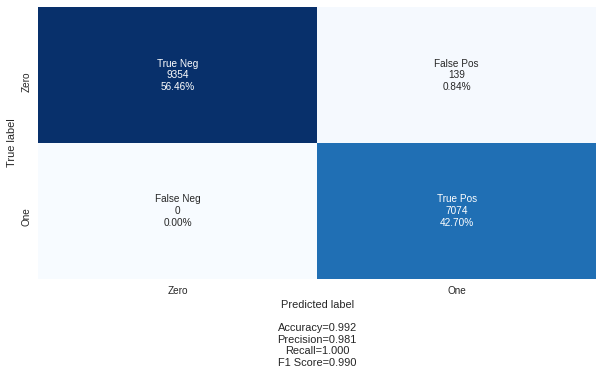

In [92]:
y_pred = pipe.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

group_names =  ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(cf_matrix, group_names,categories, cbar=False)